# Capstone Project
## Investigating the relationship between the spread of COVID-19 and income/education levels in the United States.

## 1. Introduction
### As the COVID-19 pandemic rages on, the world continues to learn more about the virus and its spread. Though many countries have made huge strides in fighting the virus, the United States struggles to effectively address and contain its spread on a large scale. As some larger cities begin to find success in "bending the curve", rural communities now appear to be suffering a delayed spike in cases and deaths. Many of these same communities (in some cases entire states) made conscious choices to not take significant action in the early stages of the pandemic, driven at least in part by the argument for civil liberty and personal choice. In this project, I will investigate possible connections to this resistance to implement large-scale public safety measures. In particular, I will try to determine whether education and income levels have played a part in communities' responses to this global crisis.

## 2. Data

### A. Data on education levels comes from the U.S. Department of Agriculture. It provides information at the county level, including total number of adults and percentage of adults who have attained varying levels of education, provided as an average from 2014-2018.

### B. Data on employment and income also comes from the USDA. It provides information at the county, including unemployment rate, number of unemployed residents, and median household income. This information is recorded by year, with the most recent data being from 2018.

### C. Information on COVID cases comes from John Hopkins University. They provide state- and county-wide data, including total cases, cases as a percent of total population, and mortality rates. This data is up to date as of 21 June 2020.

## 3. Methodology

In [186]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

Download data and create tables with relevant columns.

In [187]:
covid = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv')
deaths = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv')

In [188]:
latlong = covid[['Province_State', 'Combined_Key', 'Lat', 'Long_']]
covid.drop(columns = ['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Country_Region', 'Lat', 'Long_', 'Combined_Key'], inplace = True)
deaths.drop(columns = ['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Country_Region', 'Lat', 'Long_', 'Combined_Key'], inplace = True)

Eliminate Null values and rows where information is 'unassigned'.

In [189]:
covid.dropna(inplace = True)
deaths.dropna(inplace = True)
covid = covid[covid.Admin2 != 'Unassigned']
covid = covid.reset_index(drop = True)
deaths = deaths[deaths.Admin2 != 'Unassigned']
deaths = deaths.reset_index(drop = True)

Rename columns so that tables match. Remove data for areas that are not actual counties (e.g., prisons). Identify and remove counties with no equivalent in covid table.

In [190]:
deaths = deaths[~deaths['Admin2'].str.contains('Out of')]
deaths = deaths[~deaths['Admin2'].str.contains('orrection')]
covid = covid[~covid['Admin2'].str.contains('Out of')]
covid = covid[~covid['Admin2'].str.contains('orrection')]
deaths.rename(columns = {'Admin2': 'County', 'Province_State': 'State'}, inplace = True)
covid.rename(columns = {'Admin2': 'County', 'Province_State': 'State'}, inplace = True)
covid['Population'] = deaths['Population']
covid = covid[['County', 'State', 'Population'] + [c for c in covid if c not in ['County', 'State', 'Population']]]
covid[covid.isnull().any(axis=1)]

,County,State,Population,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,...,6/15/20,6/16/20,6/17/20,6/18/20,6/19/20,6/20/20,6/21/20,6/22/20,6/23/20,6/24/20
3193,Dukes and Nantucket,Massachusetts,NaN,0,0,0,0,0,0,0,...,0,57,57,57,57,57,57,59,59,59
3194,Kansas City,Missouri,NaN,0,0,0,0,0,0,0,...,1737,1762,1802,1831,1872,1914,1921,1945,2014,2057


In [191]:
covid = covid[~covid.isnull().any(axis=1)]
deaths = deaths[(deaths.County != 'Dukes and Nantucket') & (deaths.County != 'Kansas City')]
print(covid.shape)
print(deaths.shape)

(3148, 158)
(3148, 158)


Create new table with COVID data from May onward. Here, we recognize that in the U.S., the beginning of May marked the beginning of a new phase in the Coronavirus outbreak. Namely, this time marked when a cultural divide became promiment and many states, counties, and individuals began to openly ignore and/or disbelieve the advice of medical experts. As a result, it may be noticed that trends in the rate of increase in cases of COVID were impacted on and after this date.

In [192]:
covid2 = pd.concat([covid[['County', 'State', 'Population']], covid[covid.columns[103:]]], axis =1)
covid2.head()

,County,State,Population,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20,...,6/15/20,6/16/20,6/17/20,6/18/20,6/19/20,6/20/20,6/21/20,6/22/20,6/23/20,6/24/20
0,Autauga,Alabama,55869.0,42,45,48,53,53,58,61,...,364,367,369,394,405,425,428,436,447,463
1,Baldwin,Alabama,223234.0,175,181,187,188,189,196,205,...,368,374,377,386,398,405,415,422,435,449
2,Barbour,Alabama,24686.0,42,43,45,45,47,47,51,...,237,244,250,262,265,271,271,276,279,287
3,Bibb,Alabama,22394.0,42,42,43,42,43,43,44,...,108,113,115,118,123,123,124,126,132,138
4,Blount,Alabama,57826.0,39,40,40,40,40,42,44,...,114,119,121,127,136,140,146,150,156,165


Create a table with the weekly rate of increase per county.

In [193]:
covid_week = pd.concat([covid2[['County', 'State', 'Population']], covid2[covid2.columns[3::7]]], axis =1)
covid_week = covid_week.reset_index(drop = True)
covid_week.head()

,County,State,Population,5/1/20,5/8/20,5/15/20,5/22/20,5/29/20,6/5/20,6/12/20,6/19/20
0,Autauga,Alabama,55869.0,42,67,103,149,212,248,323,405
1,Baldwin,Alabama,223234.0,175,208,244,271,282,296,353,398
2,Barbour,Alabama,24686.0,42,53,79,104,147,183,221,265
3,Bibb,Alabama,22394.0,42,44,49,55,71,76,97,123
4,Blount,Alabama,57826.0,39,44,45,49,60,64,95,136


In [194]:
for index, row in covid_week.iterrows():
    for i in range(len(covid_week.columns) - 3):
        if row[i + 2] != 0:
            covid_week.iloc[index, i + 3] = row[i + 3] / row[i + 2]
        else:
            covid_week.iloc[index, i + 2] = np.nan
covid_week.tail()

,County,State,Population,5/1/20,5/8/20,5/15/20,5/22/20,5/29/20,6/5/20,6/12/20,6/19/20
3143,Central Utah,Utah,NaN,23.0,1.173913,1.074074,1.172414,1.117647,1.105263,1.452381,1.459016
3144,Southeast Utah,Utah,NaN,13.0,1.000000,1.000000,1.384615,1.277778,1.130435,1.076923,1.107143
3145,Southwest Utah,Utah,NaN,101.0,1.366337,1.449275,1.405000,1.373665,1.435233,1.333935,1.317997
3146,TriCounty,Utah,NaN,13.0,1.076923,1.142857,1.312500,0.857143,1.111111,1.350000,1.407407
3147,Weber-Morgan,Utah,NaN,162.0,1.135802,1.173913,1.166667,1.142857,1.225694,1.243626,1.403189


In [195]:
covid_week.drop(columns = ['5/1/20'], inplace = True)

Drop Null values and find the average weekly rate of increase.

In [196]:
covid_week2 = covid_week.dropna()
covid_week2 = covid_week2.reset_index(drop = True)
covid_week2.shape

(2857, 10)

In [197]:
covid_week2 = pd.concat([covid_week2[['County', 'State']], covid_week2[covid_week2.columns[3:]]], axis = 1)
covid_week2['avg_ROI'] = covid_week2.mean(axis = 1).to_frame()
covid_week2.tail(5)

,County,State,5/8/20,5/15/20,5/22/20,5/29/20,6/5/20,6/12/20,6/19/20,avg_ROI
2852,Sublette,Wyoming,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.333333,1.047619
2853,Sweetwater,Wyoming,1.055556,1.157895,1.136364,1.040000,1.230769,1.187500,1.263158,1.153034
2854,Teton,Wyoming,1.020833,1.010204,1.010101,1.000000,1.000000,1.040000,1.048077,1.018459
2855,Uinta,Wyoming,1.125000,1.000000,1.444444,0.923077,1.583333,3.263158,2.064516,1.629076
2856,Washakie,Wyoming,1.000000,1.125000,2.222222,1.750000,1.114286,1.000000,1.000000,1.315930


 Filter out counties with small populations (under 10000), which would likely contribute to very low transmission rates (outliers). Also filter out counties where consecutive weeks had identical case totals (likely indicating insufficient testing and, as a result, unreliable or misleading data).

In [198]:
covid_week2 = covid_week2[covid_week2['5/8/20'] != 1]
covid_week2 = covid_week2[covid_week2['5/15/20'] != 1]
covid_week2 = covid_week2[covid_week2['5/22/20'] != 1]
covid_week2 = covid_week2[covid_week2['5/29/20'] != 1]
covid_week2 = covid_week2[covid_week2['6/5/20'] != 1]
covid_week2 = covid_week2[covid_week2['6/12/20'] != 1]
covid_week2 = covid_week2[covid_week2['6/19/20'] != 1]
covid_week2.shape

(1545, 10)

In [199]:
covid_week2 = covid_week.dropna()[covid_week.Population > 10000]
covid_week2 = pd.concat([covid_week2[['County', 'State']], covid_week2[covid_week2.columns[3:]]], axis = 1)
covid_week2['avg_ROI'] = covid_week2.mean(axis = 1).to_frame()
covid_week2.shape
covid_week2.head()

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


,County,State,5/8/20,5/15/20,5/22/20,5/29/20,6/5/20,6/12/20,6/19/20,avg_ROI
0,Autauga,Alabama,1.595238,1.537313,1.446602,1.422819,1.169811,1.302419,1.253870,1.389725
1,Baldwin,Alabama,1.188571,1.173077,1.110656,1.040590,1.049645,1.192568,1.127479,1.126084
2,Barbour,Alabama,1.261905,1.490566,1.316456,1.413462,1.244898,1.207650,1.199095,1.304862
3,Bibb,Alabama,1.047619,1.113636,1.122449,1.290909,1.070423,1.276316,1.268041,1.169913
4,Blount,Alabama,1.128205,1.022727,1.088889,1.224490,1.066667,1.484375,1.431579,1.206705


In [200]:
covid_ROI = covid_week2[['County', 'State', 'avg_ROI']]
covid_ROI.head()

,County,State,avg_ROI
0,Autauga,Alabama,1.389725
1,Baldwin,Alabama,1.126084
2,Barbour,Alabama,1.304862
3,Bibb,Alabama,1.169913
4,Blount,Alabama,1.206705


Get county-level education data, including totals and percents of residents who have attained a high school diploma, college degree, etc. Rename columns for ease of use, rename state values to match previous tables, remove rows that are not states (e.g., Puerto Rico) and those that gives state totals (listed as counties themselves).

In [201]:
!wget -O Education.xls https://www.ers.usda.gov/webdocs/DataFiles/48747/Education.xls?v=9048.8

--2020-06-25 16:26:23--  https://www.ers.usda.gov/webdocs/DataFiles/48747/Education.xls?v=9048.8
Resolving www.ers.usda.gov (www.ers.usda.gov)... 13.72.9.120
Connecting to www.ers.usda.gov (www.ers.usda.gov)|13.72.9.120|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1420288 (1.4M) [application/vnd.ms-excel]
Saving to: ‘Education.xls’

100%[======================================>] 1,420,288   4.96MB/s   in 0.3s   

2020-06-25 16:26:23 (4.96 MB/s) - ‘Education.xls’ saved [1420288/1420288]



In [202]:
ed = pd.read_excel('Education.xls', header = 4)
ed = ed.iloc[:, np.r_[1:3, -4:0]]
ed.dropna(inplace = True)
ed.rename(columns = {'Percent of adults with less than a high school diploma, 2014-18': '% no_diploma',
                    'Percent of adults with a high school diploma only, 2014-18': '% hs_diploma',
                    "Percent of adults completing some college or associate's degree, 2014-18": '% some_college',
                    "Percent of adults with a bachelor's degree or higher, 2014-18": '% bach_plus',
                    'Area name': 'County'}, inplace = True)

states = ['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 
          'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Lousiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 
         'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 
         'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia',
         'Washington', 'West Virginia', 'Wisconsin', 'Wyoming']

ed = ed[ed.State != 'PR']
ed = ed[ed.State != 'US']
ed = ed[~ed['County'].isin(states)]
ed = ed.reset_index(drop = True)
ed.replace({'State' : { 'AL': 'Alabama', 'AK': 'Alaska', 'AZ': 'Arizona', 'AR': 'Arkansas', 'CA': 'California', 'CO': 'Colorado',
                      'CT': 'Connecticut', 'DE': 'Delaware', 'FL': 'Florida', 'GA': 'Georgia', 'HI': 'Hawaii', 'ID': 'Idaho', 'IL': 'Illinois',
                      'IN': 'Indiana', 'IA': 'Iowa', 'KS': 'Kansas', 'LA': 'Louisiana', 'ME': 'Maine', 'MD': 'Maryland', 'MA': 'Massachusetts',
                      'MI': 'Michigan', 'MN': 'Minnesota', 'MS': 'Mississippi', 'MO': 'Missouri', 'MT': 'Montana', 'NE': 'Nebraska', 'NV': 'Nevada',
                      'NH': 'New Hampshire', 'NJ': 'New Jersey', 'NM': 'New Mexico', 'NY': 'New York', 'NC': 'North Carolina', 'ND': 'North Dakota',
                      'OH': 'Ohio', 'OK': 'Oklahoma', 'OR': 'Oregon', 'PA': 'Pennsylvania', 'RI': 'Rhode Island', 'SC': 'South Carolina', 
                      'SD': 'South Dakota', 'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah', 'VT': 'Vermont', 'VA': 'Virginia', 'WA': 'Washington', 
                      'WV': 'West Virginia', 'WI': 'Wisconsin', 'WY': 'Wyoming', 'DC': 'District of Columbia', 'KY': 'Kentucky'}}, inplace = True)

This source lists counties with a variety of endings, whereas the COVID-related sources do not. Here, we eliminate these endings so that values match those in previous tables.

In [203]:
for index, row in ed.iterrows():
    if row['County'].endswith('County'):
        ed.loc[index, 'County'] = ed.loc[index, 'County'][:-7]
    elif row['County'].endswith('City and Borough'):
        ed.loc[index, 'County'] = ed.loc[index, 'County'][:-17]
    elif row['County'].endswith('Borough'):
        ed.loc[index, 'County'] = ed.loc[index, 'County'][:-8]
    elif row['County'].endswith('Borough/municipality'):
        ed.loc[index, 'County'] = ed.loc[index, 'County'][:-21]
    elif row['County'].endswith('Borough/city'):
        ed.loc[index, 'County'] = ed.loc[index, 'County'][:-13]
    elif row['County'].endswith('Municipality'):
        ed.loc[index, 'County'] = ed.loc[index, 'County'][:-13]
    elif row['County'].endswith('Parish'):
        ed.loc[index, 'County'] = ed.loc[index, 'County'][:-7]
    elif row['County'].endswith('County/town'):
        ed.loc[index, 'County'] = ed.loc[index, 'County'][:-12]
    elif row['County'].endswith('County/city'):
        ed.loc[index, 'County'] = ed.loc[index, 'County'][:-12]
    elif row['County'].endswith('Census Area'):
        ed.loc[index, 'County'] = ed.loc[index, 'County'][:-12]
    elif row['State'] == 'Virginia' and row['County'].endswith('city'):
        ed.loc[index, 'County'] = ed.loc[index, 'County'][:-5]

Download county-level data related to residents' income. Perform cleaning similar to education data.

In [204]:
!wget -O income.xls https://www.ers.usda.gov/webdocs/DataFiles/48747/Unemployment.xls?v=9048.8

--2020-06-25 16:26:29--  https://www.ers.usda.gov/webdocs/DataFiles/48747/Unemployment.xls?v=9048.8
Resolving www.ers.usda.gov (www.ers.usda.gov)... 13.72.9.120
Connecting to www.ers.usda.gov (www.ers.usda.gov)|13.72.9.120|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2322944 (2.2M) [application/vnd.ms-excel]
Saving to: ‘income.xls’

100%[======================================>] 2,322,944   7.04MB/s   in 0.3s   

2020-06-25 16:26:30 (7.04 MB/s) - ‘income.xls’ saved [2322944/2322944]



In [205]:
income = pd.read_excel('income.xls', header = 7)
income = income.iloc[:, np.r_[1:3, -6:0]]
income.dropna(inplace = True)
income[['County', 'Extra']] = income.area_name.str.split(',', expand = True)
income.area_name = income.County
income.drop(columns = ['County', 'Extra'], inplace = True)
income.rename(columns = {'Stabr': 'State', 'area_name': 'County'}, inplace = True)
income = income[income.State != 'PR']
income = income[income.State != 'US']
income = income[~income['County'].isin(states)]
income = income.reset_index(drop = True)
income.replace({'State' : { 'AL': 'Alabama', 'AK': 'Alaska', 'AZ': 'Arizona', 'AR': 'Arkansas', 'CA': 'California', 'CO': 'Colorado',
                      'CT': 'Connecticut', 'DE': 'Delaware', 'FL': 'Florida', 'GA': 'Georgia', 'HI': 'Hawaii', 'ID': 'Idaho', 'IL': 'Illinois',
                      'IN': 'Indiana', 'IA': 'Iowa', 'KS': 'Kansas', 'LA': 'Louisiana', 'ME': 'Maine', 'MD': 'Maryland', 'MA': 'Massachusetts',
                      'MI': 'Michigan', 'MN': 'Minnesota', 'MS': 'Mississippi', 'MO': 'Missouri', 'MT': 'Montana', 'NE': 'Nebraska', 'NV': 'Nevada',
                      'NH': 'New Hampshire', 'NJ': 'New Jersey', 'NM': 'New Mexico', 'NY': 'New York', 'NC': 'North Carolina', 'ND': 'North Dakota',
                      'OH': 'Ohio', 'OK': 'Oklahoma', 'OR': 'Oregon', 'PA': 'Pennsylvania', 'RI': 'Rhode Island', 'SC': 'South Carolina', 
                      'SD': 'South Dakota', 'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah', 'VT': 'Vermont', 'VA': 'Virginia', 'WA': 'Washington', 
                      'WV': 'West Virginia', 'WI': 'Wisconsin', 'WY': 'Wyoming', 'DC': 'District of Columbia', 'KY': 'Kentucky'}}, inplace = True)

In [206]:
for index, row in income.iterrows():
    if row['County'].endswith('County'):
        income.loc[index, 'County'] = income.loc[index, 'County'][:-7]
    elif row['County'].endswith('City and Borough'):
        income.loc[index, 'County'] = income.loc[index, 'County'][:-17]
    elif row['County'].endswith('Borough'):
        income.loc[index, 'County'] = income.loc[index, 'County'][:-8]
    elif row['County'].endswith('Borough/municipality'):
        income.loc[index, 'County'] = income.loc[index, 'County'][:-21]
    elif row['County'].endswith('Borough/city'):
        income.loc[index, 'County'] = income.loc[index, 'County'][:-13]
    elif row['County'].endswith('Municipality'):
        income.loc[index, 'County'] = income.loc[index, 'County'][:-13]
    elif row['County'].endswith('Parish'):
        income.loc[index, 'County'] = income.loc[index, 'County'][:-7]
    elif row['County'].endswith('County/town'):
        income.loc[index, 'County'] = income.loc[index, 'County'][:-12]
    elif row['County'].endswith('County/city'):
        income.loc[index, 'County'] = income.loc[index, 'County'][:-12]
    elif row['County'].endswith('Census Area'):
        income.loc[index, 'County'] = income.loc[index, 'County'][:-12]
    elif row['State'] == 'Virginia' and row['County'].endswith('city'):
        income.loc[index, 'County'] = income.loc[index, 'County'][:-5]

Create new income table with only median household income.

In [207]:
income2 = income[['State', 'County', 'Median_Household_Income_2018']]
income2.head()

,State,County,Median_Household_Income_2018
0,Alabama,Autauga,59338.0
1,Alabama,Baldwin,57588.0
2,Alabama,Barbour,34382.0
3,Alabama,Bibb,46064.0
4,Alabama,Blount,50412.0


Create table combining COVID data with median income.

In [208]:
covid_inc = pd.merge(income2, covid_ROI, on = ['County','State'])
covid_inc.head()

,State,County,Median_Household_Income_2018,avg_ROI
0,Alabama,Autauga,59338.0,1.389725
1,Alabama,Baldwin,57588.0,1.126084
2,Alabama,Barbour,34382.0,1.304862
3,Alabama,Bibb,46064.0,1.169913
4,Alabama,Blount,50412.0,1.206705


Group education data into two possible categories: college degree and no college degree. Rename columns

In [209]:
ed_comb = ed.copy()
ed_comb['no_degree'] = ed_comb['% no_diploma'] + ed_comb['% hs_diploma'] + ed_comb['% some_college']
ed_comb.drop(columns = ['% no_diploma', '% hs_diploma', '% some_college'], inplace = True)
ed_comb.rename(columns = {'% bach_plus': 'degree'}, inplace = True)

Combine education and covid data.

In [210]:
covid_ed = pd.merge(covid_ROI, ed_comb, on = ['County','State'])

Get overview of cases by state.

In [211]:
covid_states = covid.groupby(['State']).sum()

In [212]:
covid_states_current = covid_states[['6/22/20']].reset_index()

In [213]:
x = covid_states_current['State'].to_list()
y = covid_states_current['6/22/20'].to_list()
x_pos = [i for i, _ in enumerate(x)]

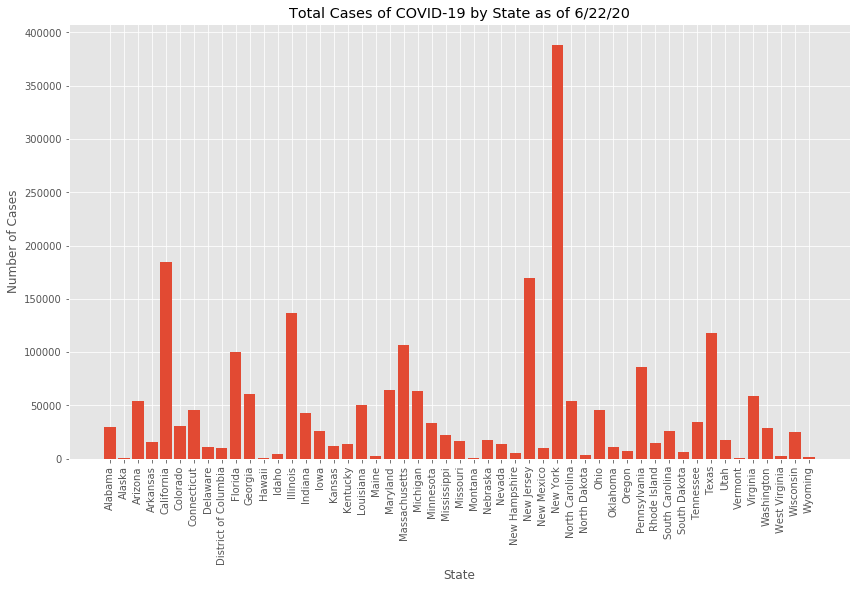

In [214]:
plt.figure(figsize=(14,8))
plt.bar(x_pos, y)
plt.xlabel('State')
plt.ylabel('Number of Cases')
plt.title('Total Cases of COVID-19 by State as of 6/22/20')
plt.xticks(x_pos, x, rotation = 90)

plt.show()

In [215]:
covid_dates = covid.drop(columns = ['County', 'State', 'Population']).sum().to_frame()

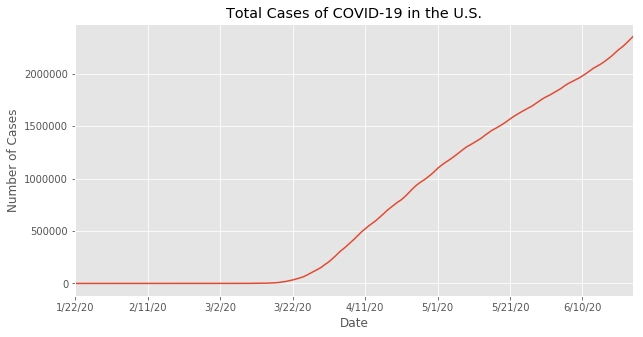

In [216]:
covid_dates.plot(figsize = (10, 5), legend = None)
plt.xlabel('Date')
plt.ylabel('Number of Cases')
plt.title('Total Cases of COVID-19 in the U.S.')

plt.show()

Show relationship between increase of COVID cases and counties' education/income levels.

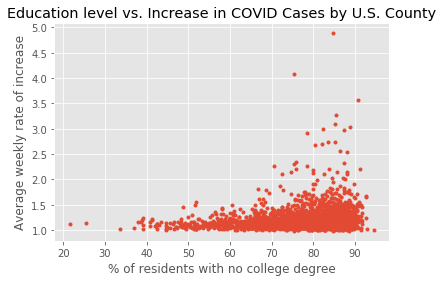

In [217]:
plt.plot(covid_ed.no_degree, covid_ed.avg_ROI, '.')
plt.xlabel('% of residents with no college degree')
plt.ylabel('Average weekly rate of increase')
plt.title('Education level vs. Increase in COVID Cases by U.S. County')
plt.show()

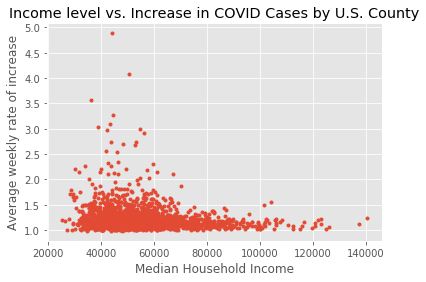

In [218]:
plt.plot(covid_inc.Median_Household_Income_2018, covid_inc.avg_ROI, '.')
plt.xlabel('Median Household Income')
plt.ylabel('Average weekly rate of increase')
plt.title('Income level vs. Increase in COVID Cases by U.S. County')
plt.show()

## 4. Results

#### For both income and education levels, there is no clear trend that ALL data follows in regards to predicting COVID rates. It is noticeable, though, that the highest weekly rates of increase occur within the lower ranges of income and education. In the education graph, we can see that although there are low rates of increase in counties of all education levels, the higher rates tends to appear more as the percent of residents lacking a college decrease increases. Note that the highest rates of increase occur almost entire after 70%. Similarly, every county with an average weekly rate of increase of about 1.7 or higher has a median household income of about 70,000 dollars or less (whereas the highest MHI is nearly double that).

## 5. Discussion

#### This project is hindered by a number of outside factors. Primarily, the continued gaps in testing capabilities (and some counties' reluctance to increase testing) means that this data is not entirely reliable for our purposes. In addition, factors including population density, total population, proximity to metropolitan areas, etc. likely all have a significant impact on the increase in COVID cases in certain counties. As a result, linking increases to a single variable is perhaps not feasible.

## 6. Conclusion

#### We conclude that the highest rates of increase in COVID cases occur in U.S. counties where median household income is in the lower half of those recorded and where 30% of residents or fewer have college degrees.